# Micrograd
So this guy is where we build a neural net from scratch.
We literally will make one, and perform back propagation by deriving some of the math


In [1]:
import numpy as np
import graphviz as gz
import matplotlib.pyplot as plt
import math
import random

%matplotlib inline


## Constructing ADT
Here we setup the initial ADT for discrete integer boxing, which will allow us to build a graph of operations that will eventually be topologically sorted to perform back propogation.
* One thing that i want to learn to do is write math formulas inline in markdown.  Please papa Andrej do this in the future.

In [2]:
class Value:
    def __init__(self, data, _children=(), _op=None, label=''):
        self._topo = None
        self.data = data
        self.label = label
        self._grad = 0.0
        self._children = set(_children)
        self._op = _op
        self._back = lambda: None
    def __repr__(self) -> str:
        if self._op == None:
            return f"Value({self.label}: {self.data: .4f})"
        else:
            return f"Value({self.label}: {self.data: .4f} = ({self._op} {[c.data for c in self._children]}))"

    def __add__(self, o) -> 'Value':
        o = o if isinstance(o, Value) else Value(o)
        out = Value(self.data + o.data, (self, o), '+')
        def _back():
            self._grad += 1.0 * out._grad
            o._grad += 1.0 * out._grad
        out._back = _back
        return out


    def __mul__(self, o) -> 'Value':
        o = o if isinstance(o, Value) else Value(o)
        out = Value(self.data * o.data, (self, o), '*')
        def _back():
            self._grad += o.data * out._grad
            o._grad += self.data * out._grad
        out._back = _back
        return out

    def __pow__(self, o) -> 'Value':
        o = o if isinstance(o, Value) else Value(o)
        out = Value(self.data ** o.data, (self, o), 'pow')
        def _back():
            self._grad += (o.data * self.data ** (o.data  - 1)) * out._grad
            # o._grad += math.log(self.data) * out.data * out._grad this is disabled because of math domain error
            # turns outs log is not valid for negative numbers here, which is a giant bummer
        out._back = _back
        return out

    def exp(self) -> 'Value':
        # f = e^x
        # df/dx = f
        out = Value(math.exp(self.data), (self,), 'exp')
        def back():
            self._grad += out.data * out._grad
        out._back = back
        return out

    def __sub__(self, o) -> 'Value':
        out = self + (o * -1) 
        return out
    
    # a / b => a * (1/b) => a * b^-1
    def __truediv__(self, o) -> 'Value':
        o = o if isinstance(o, Value) else Value(o)
        out = self * (o ** (-1))
        return out
        
    
    def tanh(self) -> 'Value':
        t = (2 * self).exp()
        tanh = (t - 1) / (t + 1)
        return tanh

    # i expanded the implementation
    # def ptanh(self) -> 'Value':
    #     t = math.exp(2 * self.data)
    #     tanh = (t - 1) / (t + 1)
    #     out = Value(tanh, (self,), 'tanh')
    #     def _back():
    #         self._grad += (1 - tanh**2) * out._grad
    #     out._back = _back
    #     return out
    

    def backward(self):
        if self._topo == None:
            topo = []
            visited = set()
            # Topological sort
            def sort(v):
                if v not in visited:
                    visited.add(v)
                    for c in v._children:
                        sort(c)
                    topo.append(v)
            sort(self)
            self._topo = list(reversed(topo))
        self._grad = 1.
        for n in self._topo:
            n._back()

    def zero_grad(self):
        self._grad = 0;
        q = [self]
        while len(q) > 0:
            n = q.pop(0)
            n._grad = 0.0
            q.extend(n._children)

    
    def __radd__(self, o) -> 'Value':
        return self + o
    def __rsub__(self, o) -> 'Value':
        return self - o
    def __rmul__(self, o) -> 'Value':
        return self * o
    def __rtruediv__(self, o) -> 'Value':
        return self / 0


## Graphing the graph
Lets plot this sucker using graphviz. Turns out the api is pretty easy to use. We can use recursion to build up our nodes in BFS order.

In [3]:
def graph_value(v: Value):
    visited = {}
    g = gz.Digraph('G', node_attr={'shape': 'record', 'color': 'blue'}, edge_attr={}, graph_attr={'rankdir': 'LR'})
    def ns(n: int, v : Value) -> str:
        g.node(str(n), f'{v.label}|{v.data : .4f}|grad: {v._grad: .4f}')
        if v._op is not None:
            n += 1
            g.node(str(n), v._op, shape='ellipse', style='filled', fillcolor='yellow')
            g.edge(str(n), str(n-1))
        n0 = n
        for v in v._children:
            assert(isinstance(n, int))
            if v not in visited:
                n0 =  n0 + 1
                n2 = ns(n0, v)
                g.edge(str(n0), str(n))
                visited[v] = str(n0)
                n0 = n2
            else:
                g.edge(visited[v], str(n))
        return n0
    ns(1,v)
    return g


# Derivatives

Given the following definition of a derivative for $f(x)$ <br>
${{df}\over{dx}}=\lim\limits_{h \to 0}{{f(x + h) - f(x)}\over{h}}$

We can now define a derivative for the following operations

* $f(g, k) = g * k$ <br>
$\implies {df\over dg} = \lim\limits_{h\to0}{((g+h) * k) - (g * k) \over h}$ <br>
$\implies {df\over dg} = \lim\limits_{h\to0}{(g* k) - (g * k) + (h*k) \over h}$ <br>
$\implies {df\over dg} = k $ <br>
$\Box$

* $f(g,k) = g + k$ <br>
$\implies {df\over dg} = \lim\limits_{h\to0}{((g+h) + k) - (g + k) \over h}$ <br>
$\implies {df\over dg} = \lim\limits_{h\to0}{(g - g) +  (k - k) + h\over h}$ <br>
$\implies {df\over dg} = 1 $ <br>
$\Box$


* $f(g,k) = g^k$ <br>

$\implies {df\over dg} = \lim\limits_{h\to0}{((g+h)^k) - (g^k) \over h}$ <br>

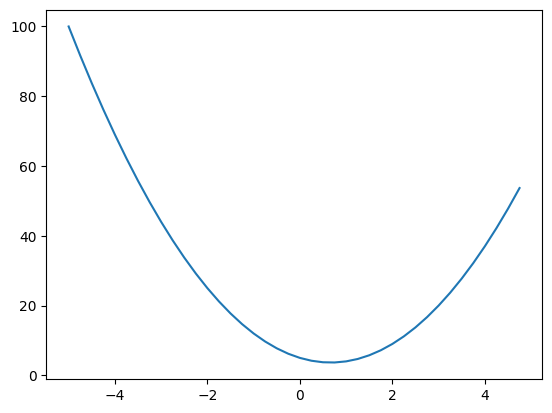

In [4]:
def f(x):
    return 3 * x** 2 - 4 * x + 5
xs = np.arange(-5, 5, .25)
ys = f(xs)

plt.plot(xs, ys)


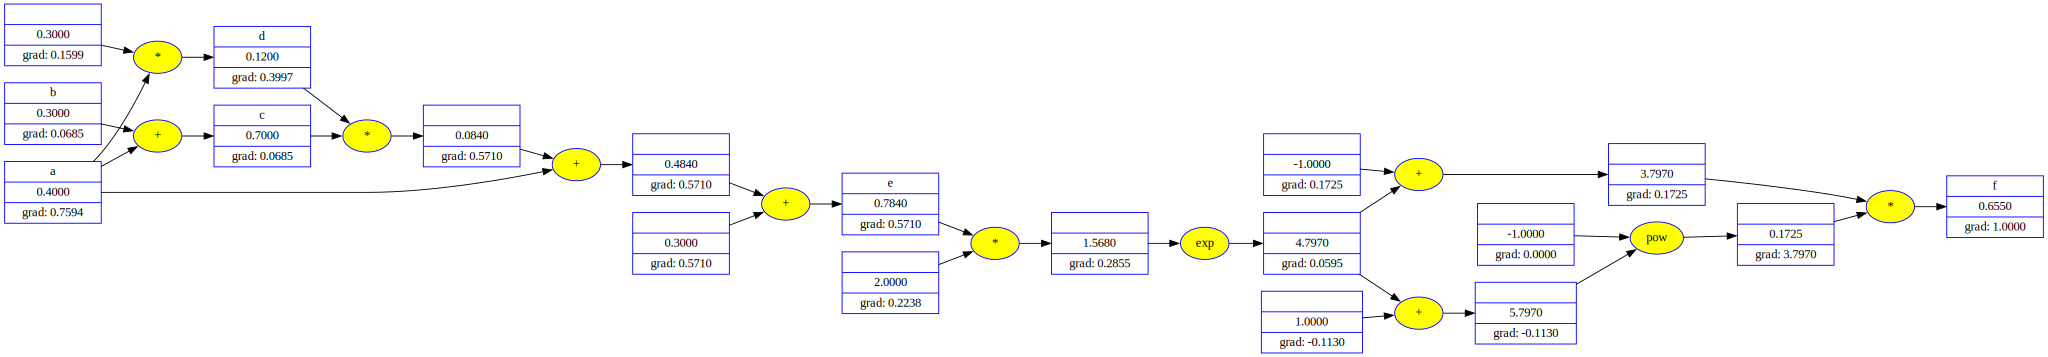

In [5]:
a = Value(.4, label='a')
b = Value(.3 , label='b')
c = a + b; c.label = 'c'
d = a * .3; d.label = 'd'
e = c * d + a + .3; e.label = 'e'
f = e.tanh(); f.label = 'f'
# f = e.ptanh(); f.label = 'f'

# print(e._children)
# print((a*a)._children)


f.zero_grad()
f.backward()
graph_value(f)

# Neurons and Layers


In [6]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self, x):
        assert(len(x) == len(self.w))
        # w dot x + b
        res = sum((w * x for w, x in zip(self.w, x)), start= self.b)
        return res.tanh()  # activation function
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

# MLP multi - layer - perceptron
class MLP:
    def __init__(self, nin, nouts):
        self._params = None
        sz = [nin] + nouts
        self.nin = nin
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
    def __call__ (self, x):
        assert(len(x) == self.nin)
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return self._params if self._params != None else[p for l in self.layers for p in l.parameters()]

    def train(self, input, pred, rate):
        """ train this MLP
        @param input array of inputs, len(input) == MLP.nin
        @param prediction array of predictions for those inputs
        """
        ypred = [self(x) for x in input]
        loss = sum((yout - ygt) ** 2 for ygt, yout in zip(pred, ypred))
        loss.zero_grad()
        loss.backward()
        ps =  self.parameters()
        for p in ps:
            p.data -= rate * p._grad
        return loss


In [7]:
n = MLP(3, [4, 4, 1])
xs = [
    [2., 3., -1.],
    [3., -1., .5],
    [.5, 1., 1.],
    [1., 1., -1.],
]

ys = [1, -1, -1, 1] #desired targets

In [8]:
for _ in range(1000):
    loss = n.train(xs, ys, 0.01)
len(loss._topo)

726

In [9]:
[n(x) for x in xs]

[Value(:  0.9748 = (* [77.45339038967401, 0.01258599532500205])),
 Value(: -0.9673 = (* [0.9836642661110568, -0.9833929782226137])),
 Value(: -0.9721 = (* [0.9860687388568471, -0.9858719168409055])),
 Value(:  0.9652 = (* [0.01739113428181129, 55.50056228625991]))]